## Confidence Interval Experiment

In [1]:
from ast import literal_eval

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns

from evaluation.notebook_utils.bar_plots import FontSizes
from evaluation.notebook_utils.combine_files import combine_files
from evaluation.notebook_utils.evaluation_columns import eval_column, Metric

# sns.set_theme(style="whitegrid")

plt.rc('text', usetex=True)

default_alpha = 0.7
# large_fonts = FontSizes(ticks=20, legend=16, labels=20,subtitle=20)
large_fonts = FontSizes(ticks=14, legend=14, labels=14,subtitle=14, bar_labels=10)
figsize = (15,2.5)
figsize_double = (15,4)

colors = [
    sns.color_palette()[0],
    sns.color_palette()[1],
    sns.color_palette()[3],
    "#34495e"
]

In [2]:
combine_files(f'experiment_data/exp_rerr_synthetic_confidence/part*', f'experiment_data/exp_rerr_synthetic_confidence/exp_rerr_synthetic_confidence.csv')

Combining 3200 files


### Synthetic Data

In [3]:
df_exp = pd.concat([pd.read_csv('experiment_data/exp_rerr_synthetic_confidence/exp_rerr_synthetic_confidence.csv')])

def return_acc(r):
    model_accuracies = r['model_accuracies']
    if model_accuracies is not None:
        try:
            list_ = literal_eval(model_accuracies)
            return list_[0][0]
        except:
            pass

    return 0
# model selection results
df_exp['training_accuracies'] = df_exp.apply(return_acc, axis=1)

for m in [Metric.RERR_RED,Metric.PRED_BASELINE,Metric.PRED_MEAN,Metric.ACTUAL_MEAN,Metric.RERR_RED_TUPLES,Metric.SUM_TUPLES,Metric.ACTUAL_NO_TUPLES,Metric.BASELINE_NO_TUPLES]:
    print(f'Adding {m}')
    df_exp[str(m)] = df_exp.apply(lambda r: eval_column(r, metric=m), axis=1)

df_exp.removal_attr = df_exp.apply(lambda r: literal_eval(r.removal_attr)[0], axis=1)
df_exp.removal_attr_bias = df_exp.apply(lambda r: literal_eval(r.removal_attr_bias)[0], axis=1)
df_exp.tuple_removal_keep_rate = df_exp.apply(lambda r: literal_eval(r.tuple_removal_keep_rate)[0], axis=1)
df_exp.synthetic_correlation = df_exp.apply(lambda r: float(r.synthetic_correlation), axis=1)
df_exp.synthetic_skew = df_exp.apply(lambda r: float(r.synthetic_skew), axis=1)

Adding nae_reduction
Adding pred_baseline
Adding pred_mean
Adding actual_mean
Adding nae_t_reduction
Adding sum_tuples
Adding actual_no_tuples
Adding baseline_no_tuples


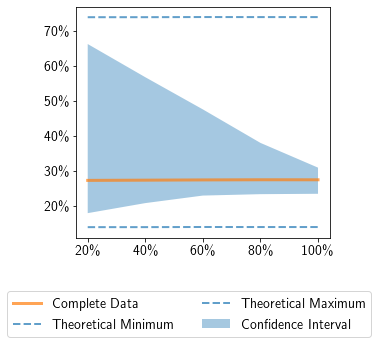

In [4]:
predictability_score = 'kl_div_prior'
# predictability_score = 'prior_val'

def plot_ci(ax, df_exp, removal_attr_bias, tuple_removal_keep_rate, predictability_score, y_label=True, x_label=True, y_label_txt='Share Attribute Value'):
    df_current = df_exp[(df_exp.removal_attr_bias == removal_attr_bias) & (df_exp.tuple_removal_keep_rate == tuple_removal_keep_rate)]
    df_lower = df_current.loc[(df_current['percentile'] == 2.5) & (df_current['predictability_score'] == predictability_score),
        ['synthetic_correlation', 'pred_mean', 'pred_baseline']].groupby(['synthetic_correlation']).mean().reset_index()
    df_upper = df_current.loc[(df_current['percentile'] == 97.5) & (df_current['predictability_score'] == predictability_score),
        ['synthetic_correlation', 'pred_mean', 'pred_baseline']].groupby(['synthetic_correlation']).mean().reset_index()
    df_true = df_current.loc[(df_current['percentile'] == 97.5) & (df_current['predictability_score'] == predictability_score),
        ['synthetic_correlation', 'actual_mean', 'pred_baseline']].groupby(['synthetic_correlation']).mean().reset_index()
    df_lower['theo_lower'] = tuple_removal_keep_rate * df_lower.pred_baseline
    df_upper['theo_upper'] = tuple_removal_keep_rate * df_upper.pred_baseline + (1-tuple_removal_keep_rate)


    ax.fill_between(df_lower.synthetic_correlation, df_lower.pred_mean, y2=df_upper.pred_mean, alpha=0.4,
                     label='Confidence Interval')
    if y_label:
        ax.set_ylabel(y_label_txt, fontsize=large_fonts.labels)
    if x_label:
        ax.set_xlabel('Predictability', fontsize=large_fonts.labels)
    ax.tick_params(labelsize=large_fonts.ticks)


    linewidth = 3
    ax.plot(df_true.synthetic_correlation, df_true.actual_mean, label='Complete Data',
             color=colors[1], alpha=default_alpha, linewidth=linewidth)
    ax.plot(df_true.synthetic_correlation, df_lower.theo_lower, label='Theoretical Minimum',
            color=colors[0], alpha=default_alpha, linewidth=linewidth-1, linestyle='--')
    ax.plot(df_true.synthetic_correlation, df_upper.theo_upper, label='Theoretical Maximum',
             color=colors[0], alpha=default_alpha, linewidth=linewidth-1, linestyle='--')

plt.figure(figsize=(5, 5))
plot_ci(plt, df_exp, 0.4, 0.4, predictability_score, x_label=False, y_label=False)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.legend(bbox_to_anchor=(-0.3, -0.2), loc=2, fontsize=large_fonts.legend, ncol=2)

plt.tight_layout()
plt.savefig('experiment_data/plots/syn_confidence_interval_0.4_0.4.pdf', bbox_inches='tight')

plt.show()

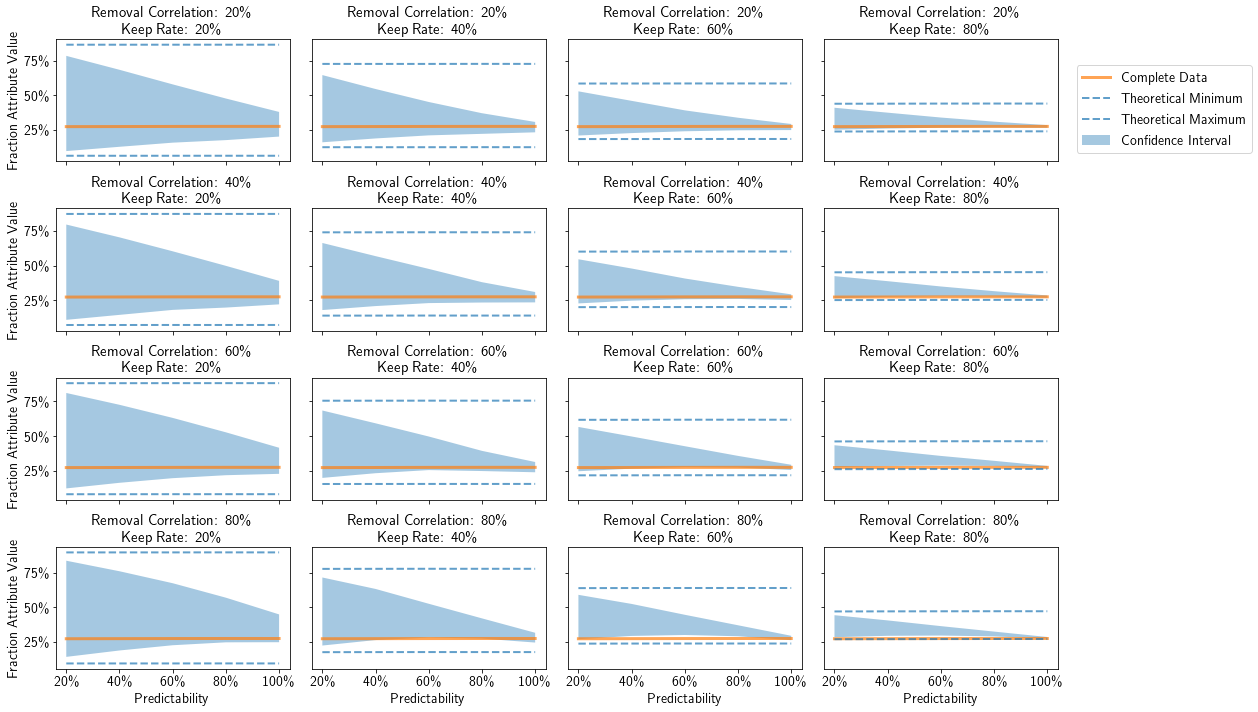

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(15,10), sharex='col', sharey='row')
y_label_text = 'Fraction Attribute Value'
# removal_attr_bias == 0.8) & (df_exp.tuple_removal_keep_rate == 0.2
for i, removal_attr_bias in enumerate([0.2, 0.4, 0.6, 0.8]):
    for j, tuple_removal_keep_rate in enumerate([0.2, 0.4, 0.6, 0.8]):
        ax = axes[i][j]
        plot_ci(ax, df_exp, removal_attr_bias, tuple_removal_keep_rate, predictability_score, x_label=i==3, y_label=j==0, y_label_txt=y_label_text)
        ax.set_title(f'Removal Correlation: {removal_attr_bias*100:.0f}\% \nKeep Rate: {tuple_removal_keep_rate*100:.0f}\%', fontsize=large_fonts.title)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.align_ylabels(axes.reshape(-1))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 5), loc=2, fontsize=large_fonts.legend, ncol=1)
plt.savefig('experiment_data/plots/syn_confidence_interval_all.pdf', bbox_inches='tight')

plt.show()

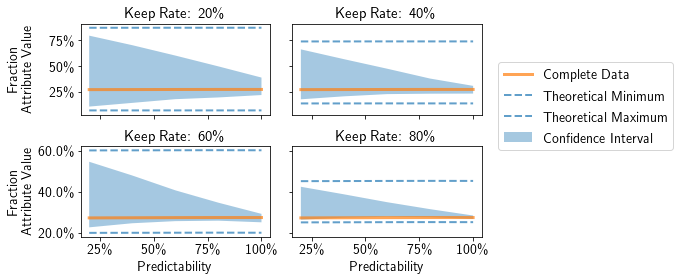

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(7,4), sharex='col', sharey='row')

y_label_text = 'Fraction \nAttribute Value'
# removal_attr_bias == 0.8) & (df_exp.tuple_removal_keep_rate == 0.2
for removal_attr_bias in [0.4]:
    for j, tuple_removal_keep_rate in enumerate([0.2, 0.4, 0.6, 0.8]):
        nrow = j // 2
        ncol = j % 2

        ax = axes[nrow][ncol]
        plot_ci(ax, df_exp, removal_attr_bias, tuple_removal_keep_rate, predictability_score, x_label=nrow==1, y_label=ncol==0,
                y_label_txt=y_label_text)
        ax.set_title(f'Keep Rate: {tuple_removal_keep_rate*100:.0f}\%', fontsize=large_fonts.title)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.align_ylabels(axes.reshape(-1))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2), loc=2, fontsize=large_fonts.legend, ncol=1)
# plt.legend(bbox_to_anchor=(-4, -0.4), loc=2, fontsize=large_fonts.legend, ncol=5)
plt.savefig('experiment_data/plots/syn_confidence_interval.pdf', bbox_inches='tight')

plt.show()

### Real-world Data

In [7]:
predictability_score = 'kl_div_prior'
# predictability_score = 'prior_val'

df_exp = pd.concat([pd.read_csv('experiment_data/exp_relative_error_airbnb/exp_relative_error.csv'),
                    pd.read_csv('experiment_data/exp_relative_error_imdb/exp_relative_error.csv')])

for m in [Metric.RERR_RED,Metric.PRED_BASELINE,Metric.PRED_MEAN,Metric.ACTUAL_MEAN,Metric.RERR_RED_TUPLES,Metric.SUM_TUPLES,Metric.ACTUAL_NO_TUPLES,Metric.BASELINE_NO_TUPLES]:
    print(f'Adding {m}')
    df_exp[str(m)] = df_exp.apply(lambda r: eval_column(r, metric=m), axis=1)

df_exp.removal_attr = df_exp.apply(lambda r: literal_eval(r.removal_attr)[0], axis=1)
df_exp.removal_attr_bias = df_exp.apply(lambda r: literal_eval(r.removal_attr_bias)[0], axis=1)
df_exp.tuple_removal_keep_rate = df_exp.apply(lambda r: literal_eval(r.tuple_removal_keep_rate)[0], axis=1)
df_exp.synthetic_correlation = df_exp.apply(lambda r: float(r.synthetic_correlation), axis=1)
df_exp.synthetic_skew = df_exp.apply(lambda r: float(r.synthetic_skew), axis=1)
df_exp['suspected_bias_choice'] = False

removal_attrs_airbnb = ['listings.price', 'listings.room_type', 'listings.property_type', 'hosts.host_since', 'hosts.host_response_rate']
removal_attrs_imdb = ['movie.production_year', 'movie.genre', 'movie.country', 'director.birth_year', 'company.country_code']
removal_attrs = removal_attrs_airbnb + removal_attrs_imdb

df_lower_bound = df_exp[(df_exp['percentile'] == 2.5) & (df_exp['predictability_score'] == predictability_score)]
df_upper_bound = df_exp[(df_exp['percentile'] == 97.5) & (df_exp['predictability_score'] == predictability_score)]
df_exp = df_exp[df_exp.percentile.isna()]

Adding nae_reduction
Adding pred_baseline
Adding pred_mean
Adding actual_mean
Adding nae_t_reduction
Adding sum_tuples
Adding actual_no_tuples
Adding baseline_no_tuples


In [8]:
def merge_bound(df_exp, df_bound, col):
    merge_cols = ['dataset', 'models', 'projected_tables', 'completion_tables',
           'tf_removals', 'tf_keep_rates', 'tuple_removal_table',
           'tuple_removal_keep_rate', 'removal_method', 'removal_attr','fully_synthetic', 'model_selection_strategy',
           'removal_attr_values', 'removal_attr_bias', 'fixed_completion_path',
                  # 'seed'
                  ]
    df_exp = pd.merge(df_exp, df_bound, left_on=merge_cols, right_on=merge_cols, suffixes=('', '_bound'))
    df_exp[col] = df_exp['pred_mean_bound']
    df_exp.drop(columns=[c for c in df_exp.columns if c.endswith('_bound')], inplace=True)
    return df_exp

df_exp = merge_bound(df_exp, df_lower_bound, 'lower_ci')
df_exp = merge_bound(df_exp, df_upper_bound, 'upper_ci')

In [9]:
def plot_ci_general(ax, df_exp, tuple_removal_keep_rate, removal_attr, y_label=True,
                    x_label=True, y_label_txt='Share Attribute Value', x_axis='removal_attr_bias',
                    x_label_txt='Predictability'):
    df_current = df_exp[(df_exp.tuple_removal_keep_rate == tuple_removal_keep_rate) &
                    (df_exp.removal_attr == removal_attr)]

    df_current = df_current.groupby([x_axis]).agg(lower_ci=('lower_ci', 'min'),
                                                  upper_ci=('upper_ci', 'max'),
                                                  actual_mean=('actual_mean', 'mean')).reset_index()
    df_current = df_current.sort_values(by=[x_axis])

    ax.fill_between(df_current[x_axis], df_current.lower_ci, y2=df_current.upper_ci, alpha=0.4,
                     label='Confidence Interval')
    if y_label:
        ax.set_ylabel(y_label_txt, fontsize=large_fonts.labels)
    if x_label:
        ax.set_xlabel(x_label_txt, fontsize=large_fonts.labels)
    ax.tick_params(labelsize=large_fonts.ticks)


    linewidth = 3
    ax.plot(df_current[x_axis], df_current.actual_mean, label='Complete Data',
             color=colors[1], alpha=default_alpha, linewidth=linewidth)

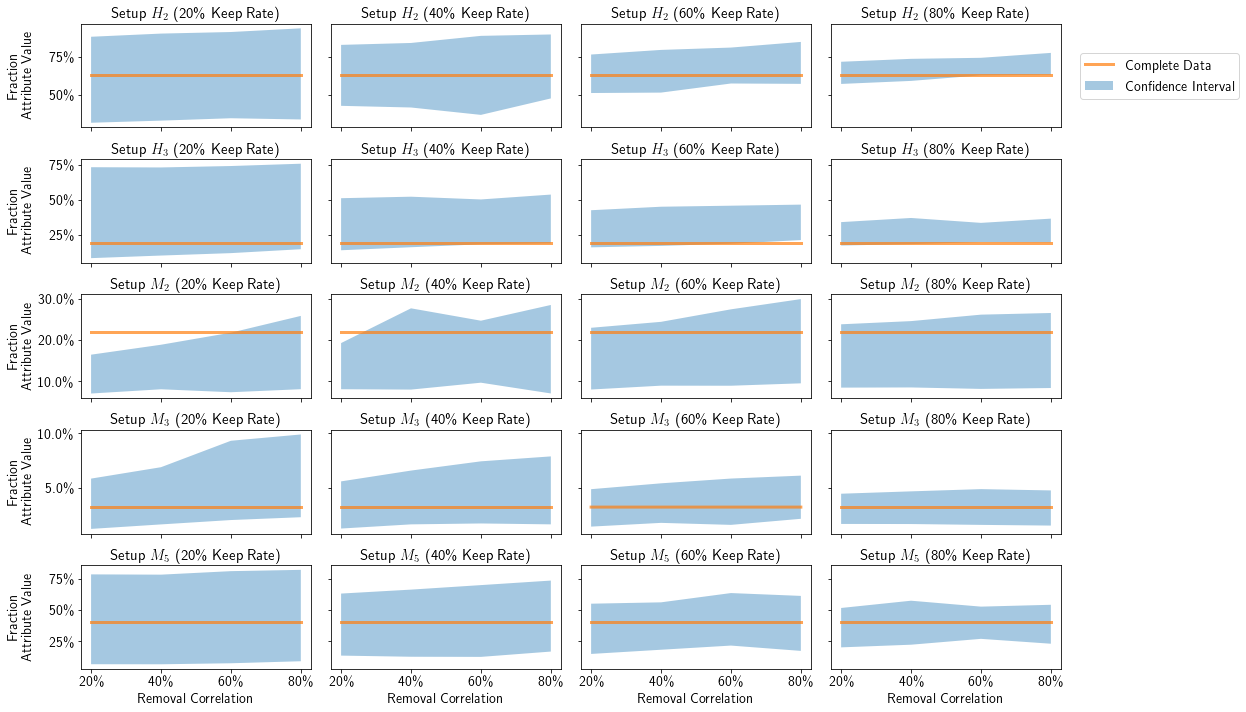

In [10]:
df_plot = df_exp

cat_attributes = ['listings.room_type', 'listings.property_type', 'movie.genre', 'movie.country', 'company.country_code']

fig, axes = plt.subplots(len(cat_attributes), 4, figsize=(15,10), sharex='col', sharey='row')
y_label_text = 'Fraction \nAttribute Value'
x_label_txt = 'Removal Correlation'

for i, attribute in enumerate(cat_attributes):
    for j, tuple_removal_keep_rate in enumerate([0.2, 0.4, 0.6, 0.8]):
        ax = axes[i][j]
        plot_ci_general(ax, df_plot, tuple_removal_keep_rate, attribute, x_label=i==len(cat_attributes)-1,
                        y_label=j==0, y_label_txt=y_label_text, x_label_txt=x_label_txt)
        if attribute in removal_attrs_airbnb:
            setup_name = f'$H_{removal_attrs_airbnb.index(attribute)+1}$'
        else:
            setup_name = f'$M_{removal_attrs_imdb.index(attribute)+1}$'
        ax.set_title(f"Setup {setup_name} ({tuple_removal_keep_rate*100:.0f}\% Keep Rate)", fontsize=large_fonts.title)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.align_ylabels(axes.reshape(-1))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 6), loc=2, fontsize=large_fonts.legend, ncol=1)
plt.savefig('experiment_data/plots/real_world_confidence_interval_all.pdf', bbox_inches='tight')

plt.show()

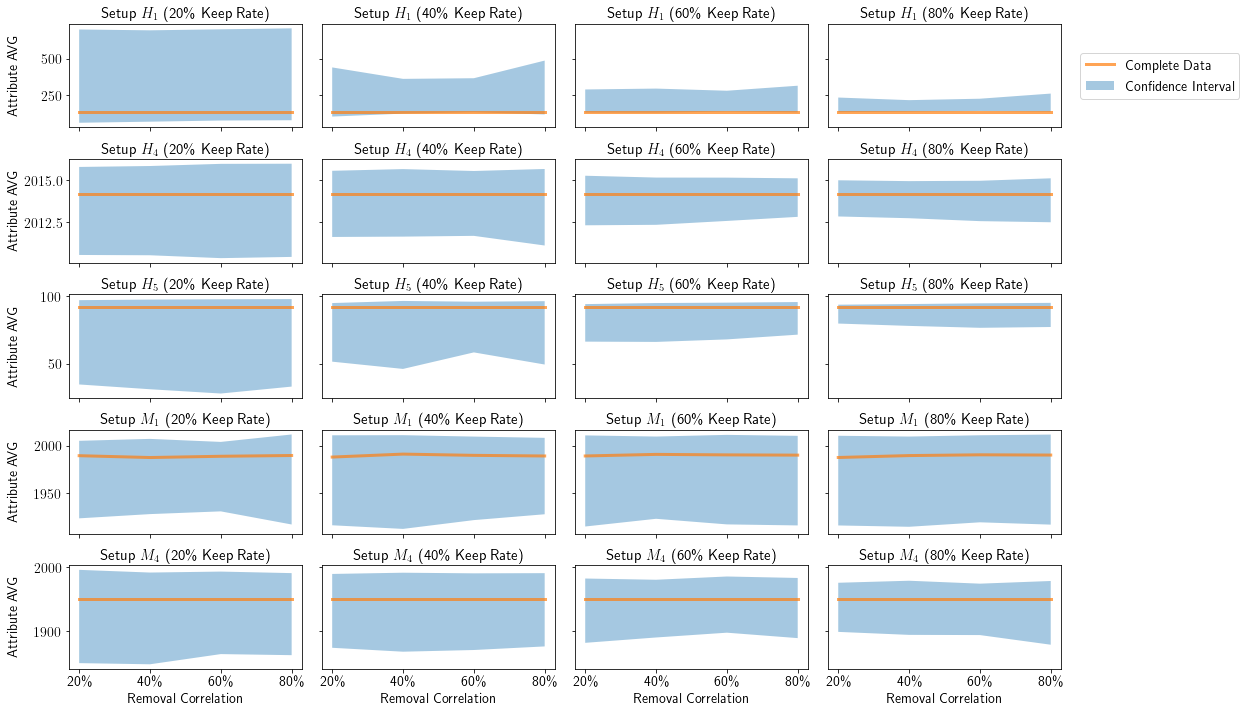

In [11]:
df_plot = df_exp

cat_attributes = ['listings.price', 'hosts.host_since', 'hosts.host_response_rate', 'movie.production_year', 'director.birth_year']

fig, axes = plt.subplots(len(cat_attributes), 4, figsize=(15,10), sharex='col', sharey='row')
y_label_text = 'Attribute AVG'
x_label_txt = 'Removal Correlation'

for i, attribute in enumerate(cat_attributes):
    for j, tuple_removal_keep_rate in enumerate([0.2, 0.4, 0.6, 0.8]):
        ax = axes[i][j]
        plot_ci_general(ax, df_plot, tuple_removal_keep_rate, attribute, x_label# ReStore - Neural Data Completion for Relational Databases

This repository contains the code for our SIGMOD'21 paper "ReStore - Neural Data Completion for Relational Databases".
Below we describe the steps required to reproduce our experiments. We additionally provide the notebooks and data that
were used to generate all plots in the paper (`exp_bias_reduction.ipynb`, `exp_confidence_intervals.ipynb`
and `exp_query_processing.ipynb`). TODO: Link

![ReStore Overview](ressources/restore.png "ReStore Overview")

## Setup

Setup Python Environment

```
python3 -m venv venv
source venv/bin/activate
pip3 install --upgrade setuptools
pip3 install --upgrade pip
pip3 install -r requirements.txt
```

The requirements contain the torch versions for GPU and Cuda 10.1. If you want to run on CPU instead, simply install the
CPU versions of pytorch.

## Reproduce Experiments

Download
the [Housing](https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B)
and [Movies Datasets](http://homepages.cwi.nl/~boncz/job/imdb.tgz)
and move them to `../research-data/incomplete-db/airbnb/all-raw` and `../research-data/incomplete-db/imdb/all-raw`.

Normalize the Data

```
python3 completion.py --preprocess --dataset airbnb --raw_data_directory ../research-data/incomplete-db/airbnb/all-raw --normalized_data_directory ../research-data/incomplete-db/airbnb/preprocessed
python3 completion.py --preprocess --dataset imdb --raw_data_directory ../research-data/incomplete-db/imdb/all-raw --normalized_data_directory ../research-data/incomplete-db/imdb/preprocessed
```

Generate the HDF files

```
python3 completion.py --generate_hdf --dataset airbnb --normalized_data_directory ../research-data/incomplete-db/airbnb/preprocessed --hdf_data_directory ../research-data/incomplete-db/airbnb/hdf_preprocessed
python3 completion.py --generate_hdf --dataset imdb --normalized_data_directory ../research-data/incomplete-db/imdb/preprocessed --hdf_data_directory ../research-data/incomplete-db/imdb/hdf_preprocessed
```

Generate all Commands for the Experiments. Append `--device cuda` if you want to run on GPU.

```
python3 exp_commands.py
```

Plots were generated using `exp_bias_reduction.ipynb`, `exp_confidence_intervals.ipynb` and `exp_query_processing.ipynb`
.

## Citation

If you find this code useful in your research, please consider citing:

=i==len(cat_attributes)-1,
                        y_label=j==0, y_label_txt=y_label_text, x_label_txt=x_label_txt)
        if attribute in removal_attrs_airbnb:
            setup_name = f'$H_{removal_attrs_airbnb.index(attribute)+1}$'
        else:
            setup_name = f'$M_{removal_attrs_imdb.index(attribute)+1}$'
        ax.set_title(f"Setup {setup_name} ({tuple_removal_keep_rate*100:.0f}\% Keep Rate)", fontsize=large_fonts.title)
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.align_ylabels(axes.reshape(-1))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 6), loc=2, fontsize=large_fonts.legend, ncol=1)
plt.savefig('experiment_data/plots/real_world_confidence_interval_cont.pdf', bbox_inches='tight')

plt.show()